# s Calibration using Si

Notebook for detector pixel to s calibration which uses silicon single crystal diffraction patterns. The notebook loads in data then visualizes the scattering pattern and asks you to select the 220 peaks that correspond to the (2-20) horizontal bragg peaks on the example image. 

## Import Packages

In [2]:
import numpy as np
import glob 
import matplotlib.pyplot as plt
import matplotlib
from datetime import date

#new code
import gued 

# interactive plotting
%matplotlib ipympl

## Load Data

/sdf/data/lcls/ds/ued_testfac/data/ueduu101/TMCP/20231107/Run/20231107_1235/*/ANDOR1_*.tif
Number of files being loaded:  53
Loading diffraction signal


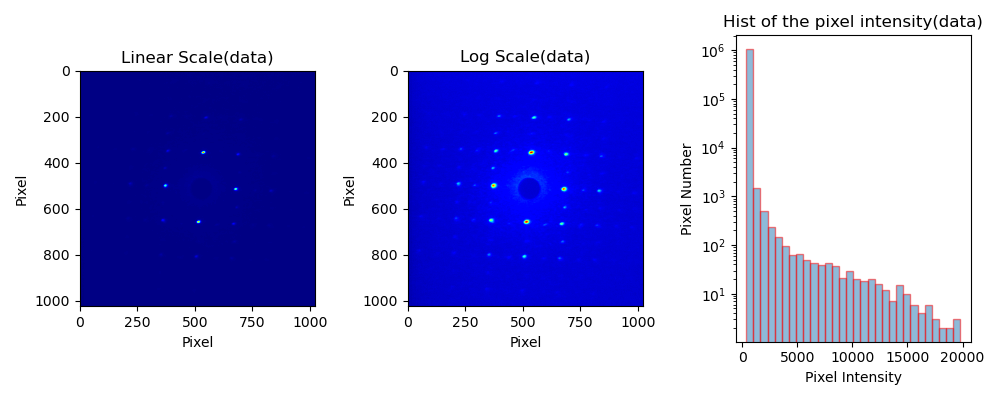

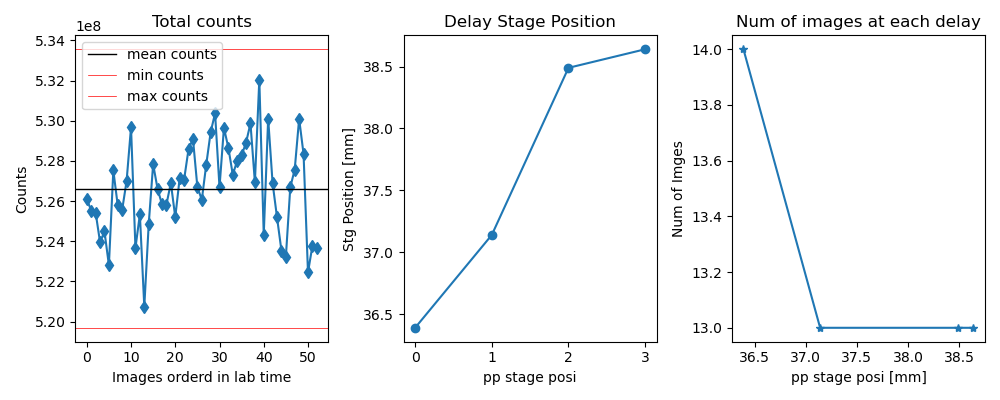

Image number read:  53


In [3]:
# Using glob and * place holders to read in all file names from the specified path
#data_path = "/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/gued_demo_data/20201027/Run/20201027_1944/"
data_path = "/sdf/data/lcls/ds/ued_testfac/data/ueduu101/TMCP/20231107/Run/20231107_1235/"
run_path = "*/ANDOR1_*.tif"

full_path = data_path + run_path
print(full_path)

files = glob.glob(full_path) 
print("Number of files being loaded: ", len(files))


print('Loading diffraction signal');
data_array, stage_positions, file_order, counts = gued.get_image_details(files[:], sort=True, plot=True, filter_data=False)

print('Image number read: ', len(counts))

image_mean = np.nanmean(data_array, axis=0) # using average image for calibration

## Show Theory Pattern

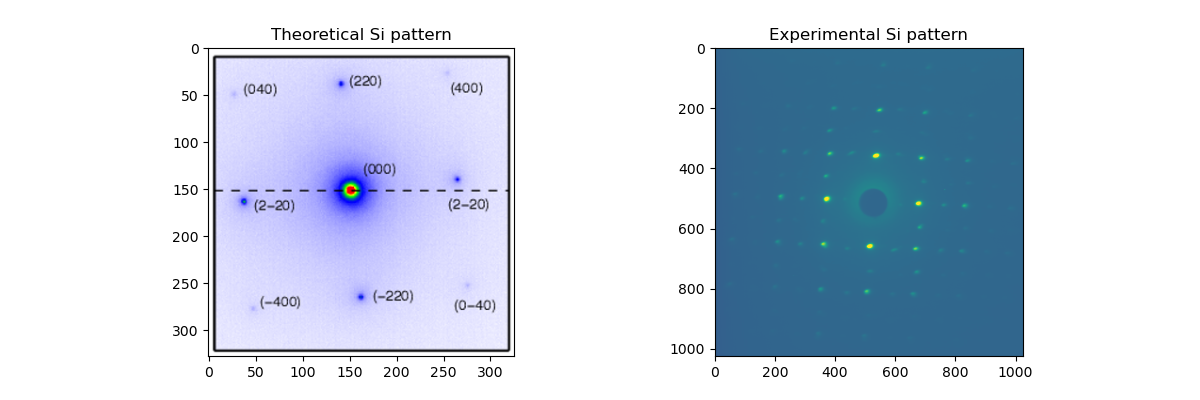

In [4]:
from skimage import io

f = 'Si_pattern.png'
img_theo = io.imread(f)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(img_theo)
plt.title('Theoretical Si pattern')
plt.subplot(1,2,2)
plt.imshow(np.log(image_mean))
plt.title('Experimental Si pattern')
plt.clim([5, 8.5])

## Select Peaks
Click on the image where the two (2-20) peaks are located

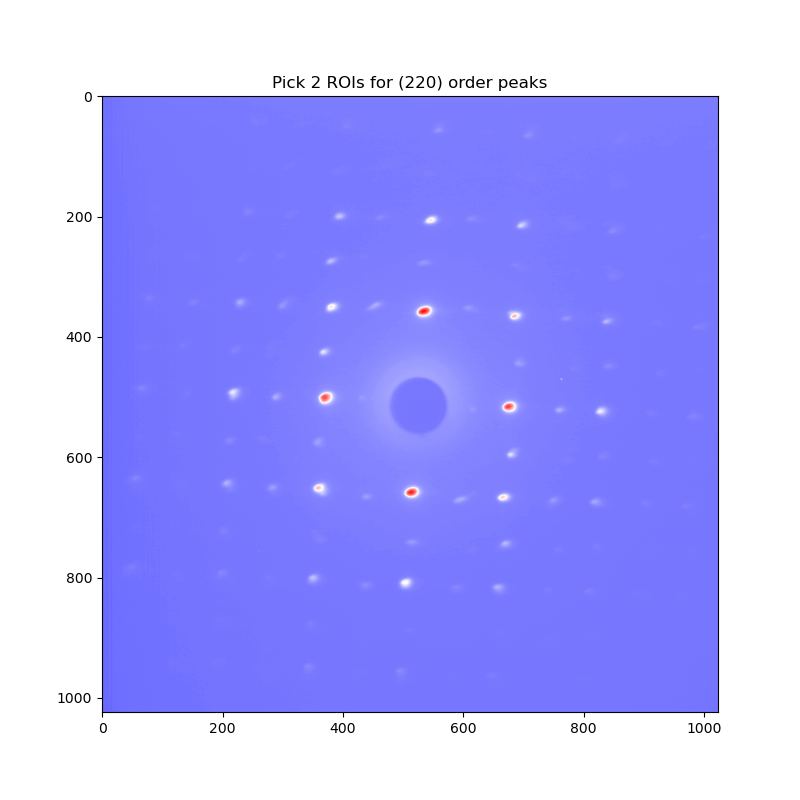

In [13]:
centroids_bragg = []

num_bragg_peak = 2

half_width = 10
mask = np.zeros_like(image_mean)


def onclick(event):
    global ix, iy
    ix, iy = int(event.xdata), int(event.ydata)
    global img_mean 
    global half_width 
    global mask 
    mask[iy-half_width:iy+half_width, ix-half_width:ix+half_width] = 1
    xy = np.argwhere(mask*image_mean==np.max(mask*image_mean))[0]
    ix = xy[1]
    iy = xy[0]


    global centroids_bragg
    centroids_bragg.append([iy, ix])
    global ax
    circle=plt.Circle((ix,iy),10, facecolor='none', edgecolor='k', linewidth=1)
    ax.add_patch(circle)
    ax.text(ix+10, iy+10, str(len(centroids_bragg)))

    global num_bragg_peak
    if len(centroids_bragg) == num_bragg_peak:
        fig.canvas.mpl_disconnect(cid)
    return centroids_bragg

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
# h = ax.imshow(np.log(img_mean), cmap='inferno')

h = ax.imshow(np.log(image_mean), cmap='bwr', vmin = np.percentile(np.log(image_mean),.5) , vmax = np.percentile(np.log(image_mean),99.5))
# h = ax.imshow((img_mean), cmap='inferno')
h.set_clim([5, 10])
ax.set_title('Pick %d ROIs for (220) order peaks'%num_bragg_peak)

cid = fig.canvas.mpl_connect('button_press_event', onclick)


In [8]:
centroids_bragg

[[500, 369], [516, 675]]

## Fit the centroids of the picked peaks 

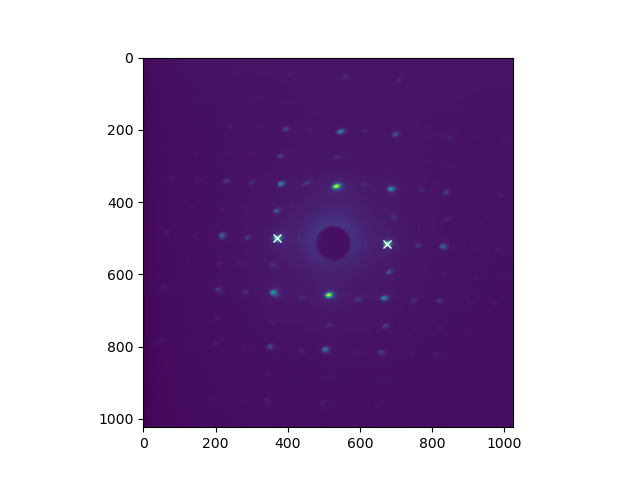

In [10]:
plt.figure()
plt.imshow(np.log(image_mean))
plt.plot(centroids_bragg[0,1], centroids_bragg[0,0], 'wx')
plt.plot(centroids_bragg[1,1], centroids_bragg[1,0], 'wx')

## Calculate q calibration 
Si lattice constatn is a=5.43 A. Theoretical q corresponding to (220) peak for Si is |q_220|=2$\pi\sqrt{2^2+2^2+0^2}/a$

In [11]:
q220_px = np.linalg.norm(centroids_bragg[0,:]-centroids_bragg[1,:])/2

a_Si = 5.43
q220_A = 2*np.pi*np.sqrt(2**2+2**2)/a_Si

q_cal = q220_A/q220_px

print(f'q calibration is {q_cal:.5f} A-1/pixel')
print(f'q range is ~{q_cal*512:.4f} A-1')

q calibration is 0.02136 A-1/pixel
q range is ~10.9373 A-1


You can now use this s calibration in the `Fast_Analysis.ipynb` notebook